In [71]:
import os
import copy
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.cm as mpl_color_map

import torch
from torch.autograd import Variable
from torchvision import models
import math
import matplotlib.pyplot as plt


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale

    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)

    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.jpg')
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image

    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs

    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize

    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.

    Args:
        example_index (int): Image id to use from examples

    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('../input_images/snake.jpg', 56),
                    ('../input_images/cat_dog.png', 243),
                    ('../input_images/spider.png', 72))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = models.alexnet(pretrained=True)
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)


In [77]:
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)
def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

In [81]:
"""
Created on Sat Nov 18 23:12:08 2017

@author: Utku Ozbulak - github.com/utkuozbulak
"""
import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models



class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
#         if not os.path.exists('../generated'):
#             os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model.base[0][self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model.base[0]):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            plt.imshow(self.created_image)
            plt.show()
            print(self.created_image.shape)
#             if i % 5 == 0:
#                 im_path = 'layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model.base[0]):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
#             if i % 5 == 0:
#                 display_images(self.created_image)
#                 im_path = '.layer_vis_l' + str(self.selected_layer) + \
#                     '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
#                 save_image(self.created_image, im_path)


In [74]:
from pytorchcv.model_provider import get_model
import torch.nn as nn
import torch
class Pooling(nn.Module):
    def __init__(self):
        super(Pooling, self).__init__()

        self.p1 = nn.AdaptiveAvgPool2d((1,1))
        self.p2 = nn.AdaptiveMaxPool2d((1,1))

    def forward(self, x):
        x1 = self.p1(x)
        x2 = self.p2(x)
        return (x1+x2) * 0.5


class Head(torch.nn.Module):
    def __init__(self, in_f, out_f):
        super(Head, self).__init__()

        self.f = nn.Flatten()
        self.l = nn.Linear(in_f, 512)
        self.d = nn.Dropout(0.5)
        self.o = nn.Linear(512, out_f)
        self.b1 = nn.BatchNorm1d(in_f)
        self.b2 = nn.BatchNorm1d(512)
        self.r = nn.ReLU()

    def forward(self, x):
        x = self.f(x)
        x = self.b1(x)
        x = self.d(x)

        x = self.l(x)
        x = self.r(x)
        x = self.b2(x)
        x = self.d(x)

        out = self.o(x)
        out = nn.Sigmoid()(out)
        return out

class FCN(torch.nn.Module):
    def __init__(self, base, in_f):
        super(FCN, self).__init__()
        self.base = base
        self.h1 = Head(in_f, 1)

    def forward(self, x):
        x = self.base(x)
        return self.h1(x)

def xception(pretrained = False):
    model = get_model("xception", pretrained=pretrained)
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))
    model = FCN(model, 2048)
    return model

In [34]:
model = xception()

In [ ]:

model.load_state_dict(torch.load('/home/tampm/code/dfd_benchmark/xception_torch_df_inthewild_checkpoint/model_pytorch_3.pt'))

model.eval()


In [36]:
import skimage.io
import cv2
import torchvision.transforms as transforms


In [37]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])

                                           ])
# image = skimage.io.imread("/hdd/tam/ff/images/train_df/0_real/952_80.jpg")
img = Image.open("/hdd/tam/ff/images/train_df/0_real/952_80.jpg")
img = transform(img)
img = img.unsqueeze(0)

In [147]:
img.shape

torch.Size([1, 3, 256, 256])

In [146]:
model._modules['base'][0][:1]

Sequential(
  (init_block): XceptionInitBlock(
    (conv1): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activ): ReLU(inplace=True)
    )
  )
)

In [139]:
conv1_img = model._modules['base'][0][:3].forward(img)

In [140]:
img_conv1 = conv1_img.detach().cpu().numpy()

In [141]:
img_conv1 = np.transpose(img_conv1[0],(1,2,0))

In [142]:
img_conv1.shape

(32, 32, 256)

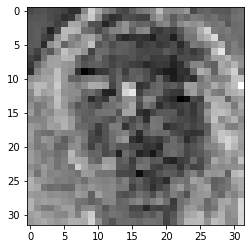

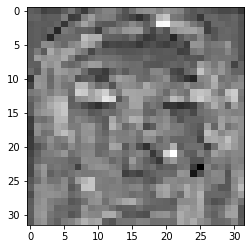

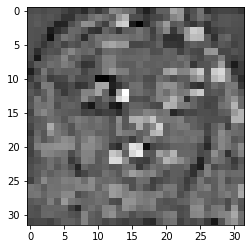

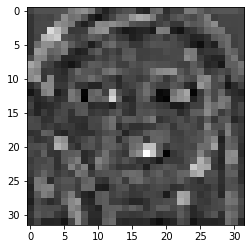

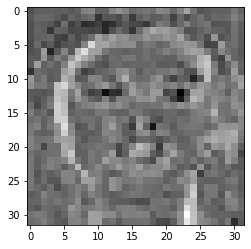

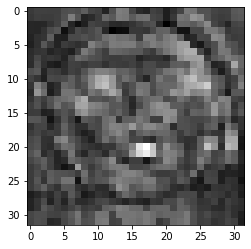

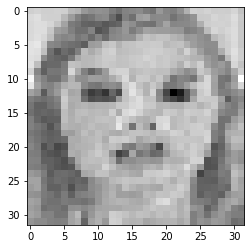

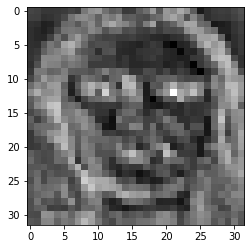

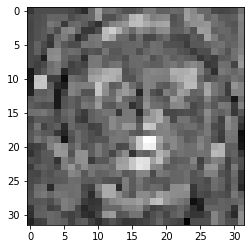

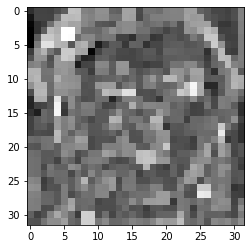

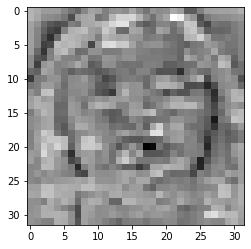

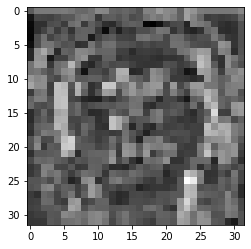

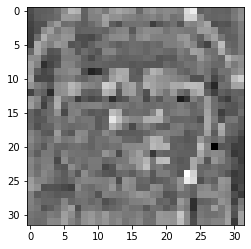

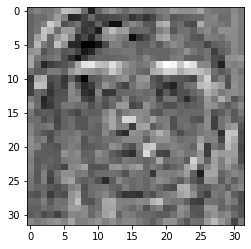

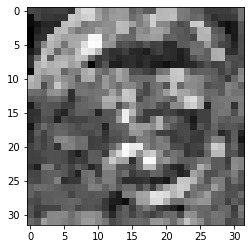

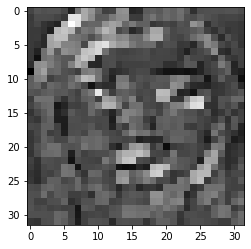

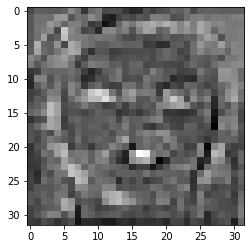

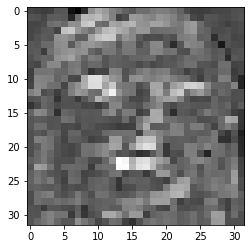

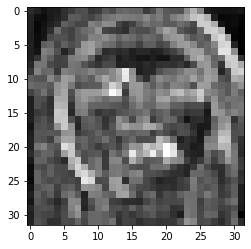

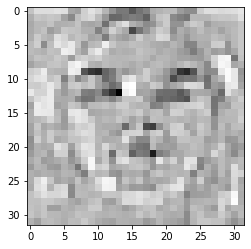

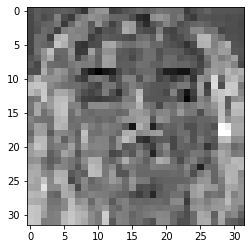

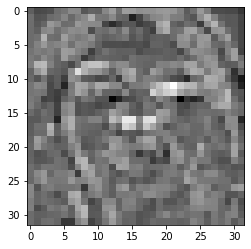

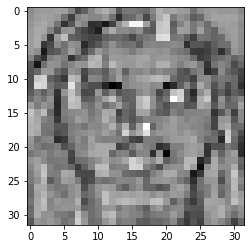

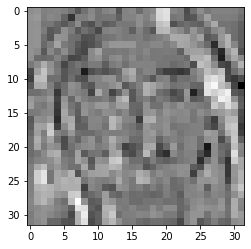

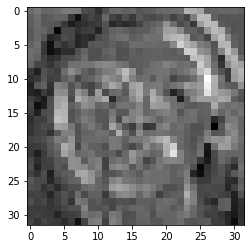

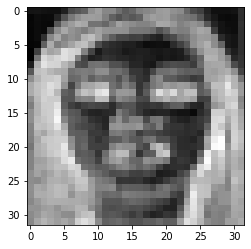

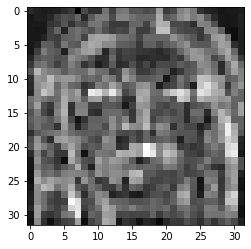

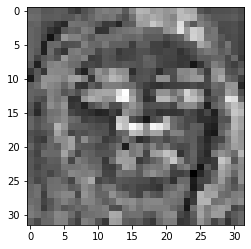

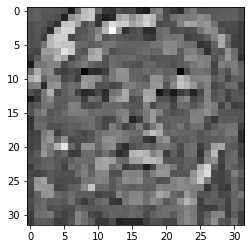

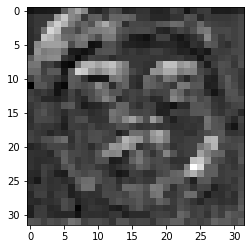

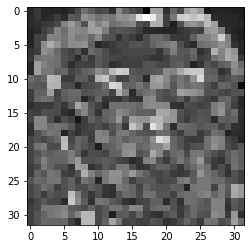

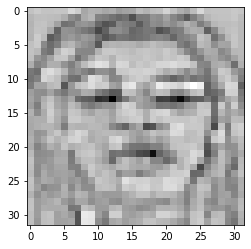

In [143]:
for i in range(32):
    plt.imshow(img_conv1[:,:,i],'gray')
    plt.show()

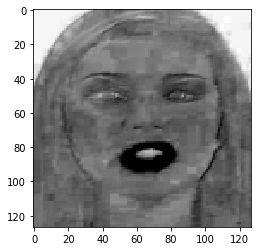

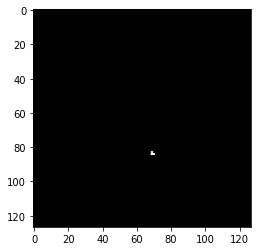

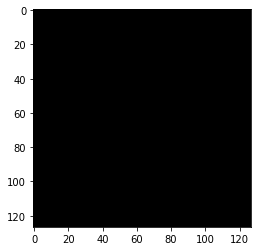

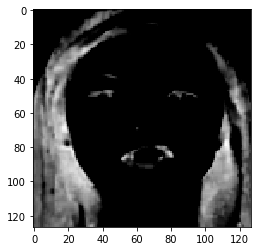

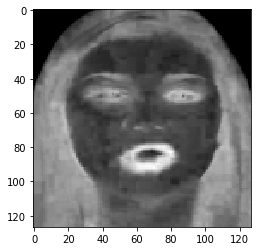

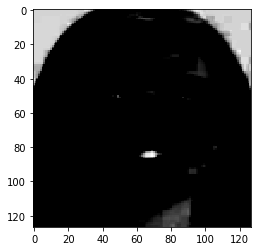

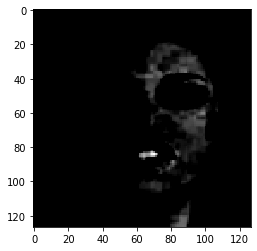

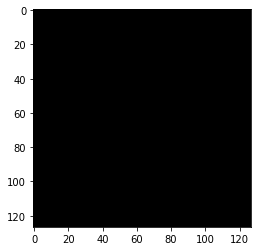

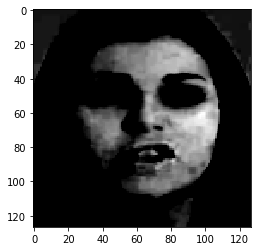

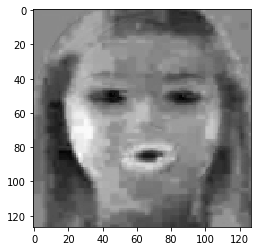

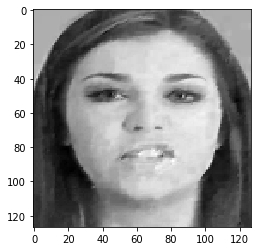

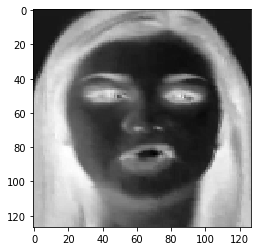

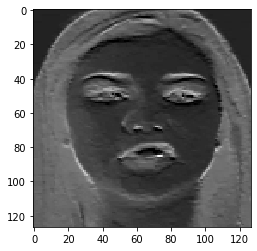

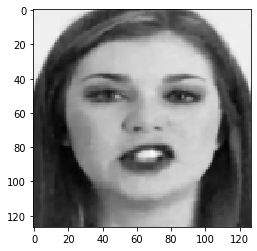

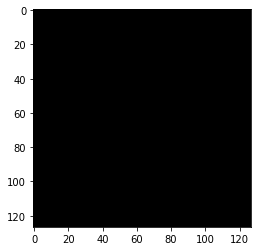

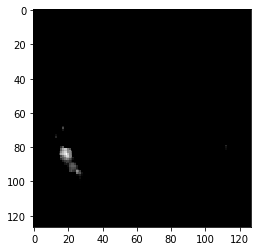

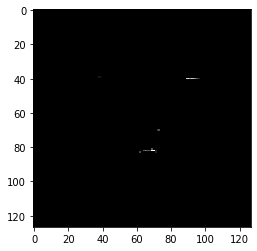

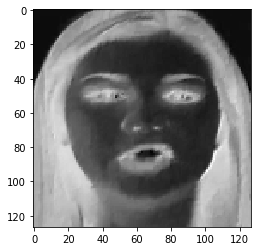

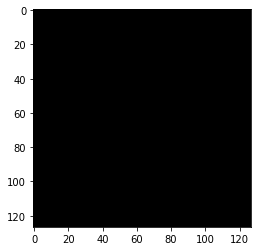

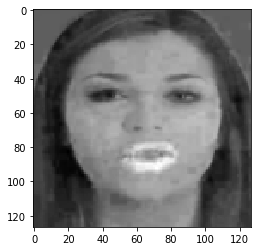

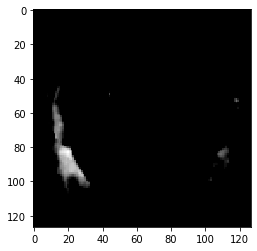

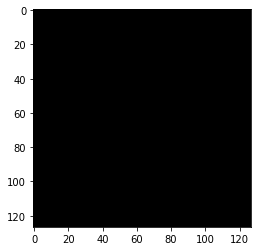

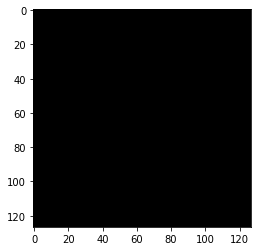

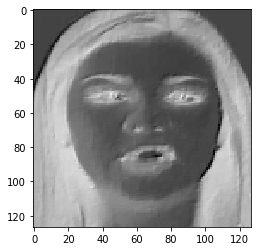

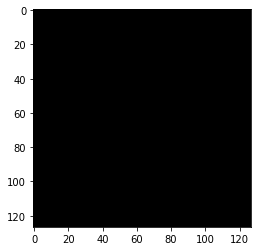

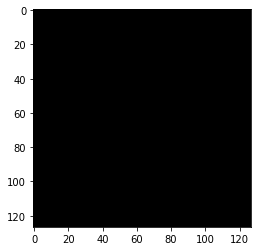

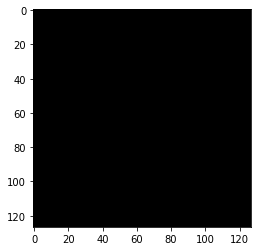

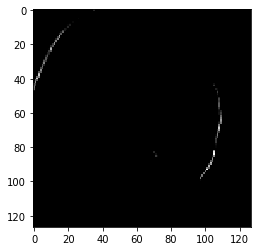

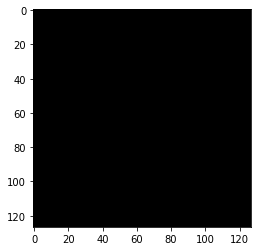

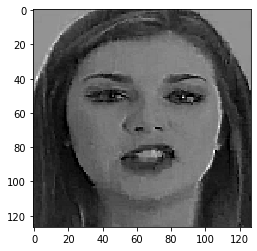

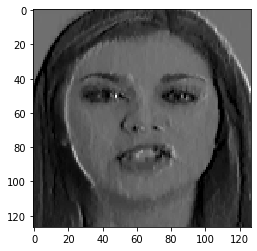

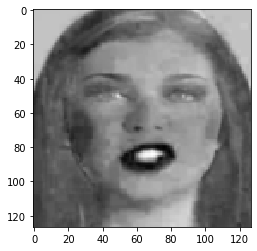

In [120]:
for i in range(32):
    plt.imshow(img_conv1[:,:,i],'gray')
    plt.show()

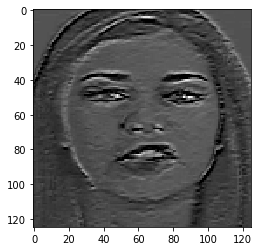

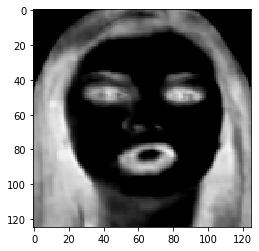

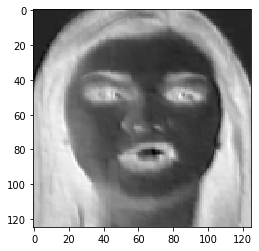

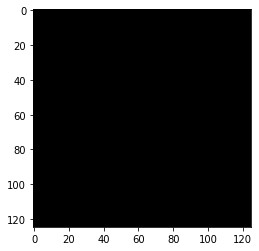

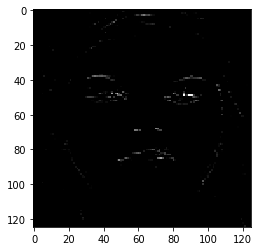

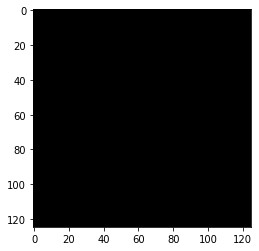

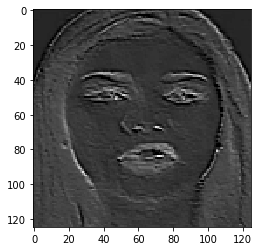

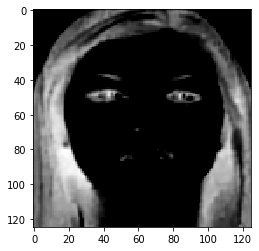

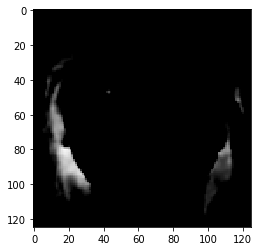

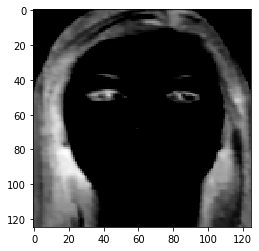

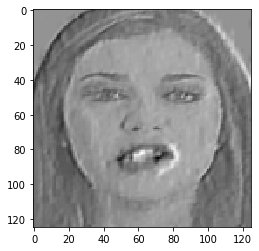

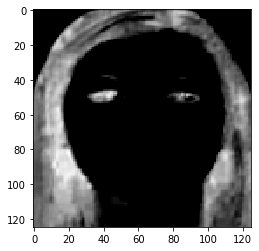

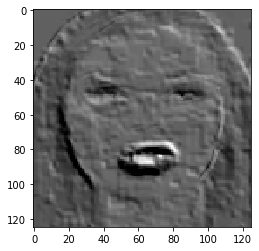

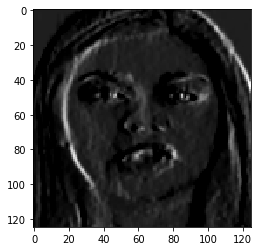

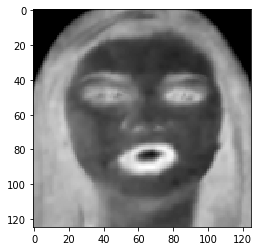

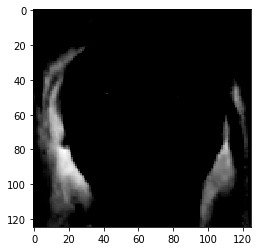

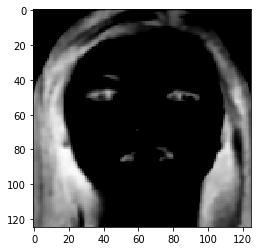

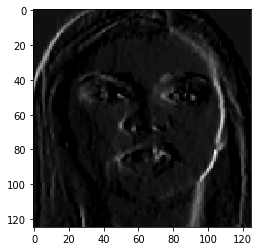

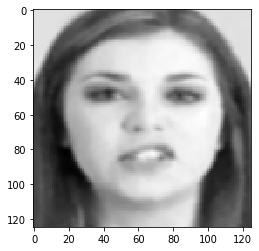

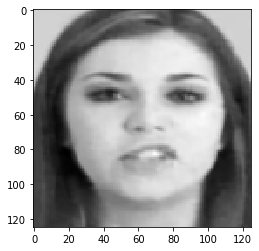

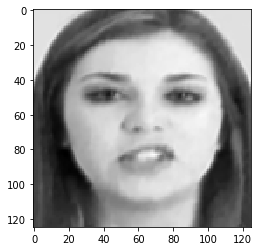

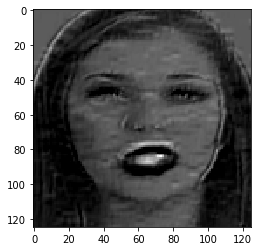

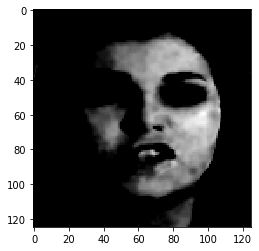

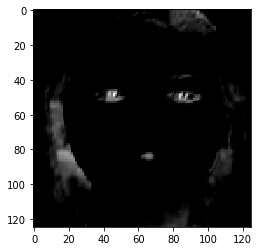

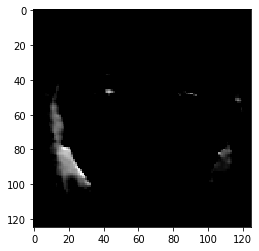

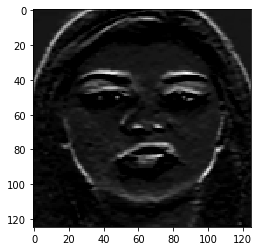

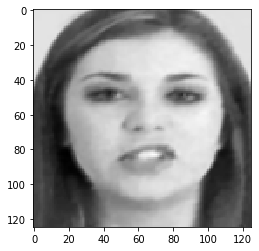

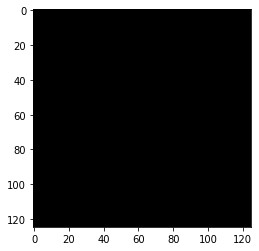

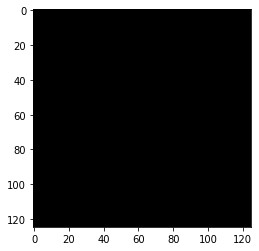

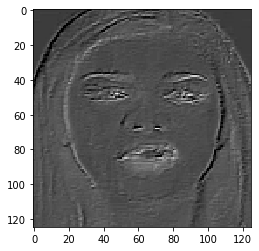

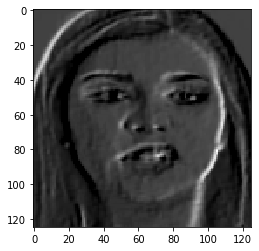

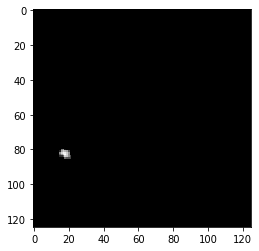

In [129]:
for i in range(32):
    plt.imshow(img_conv1[:,:,i],'gray')
    plt.show()

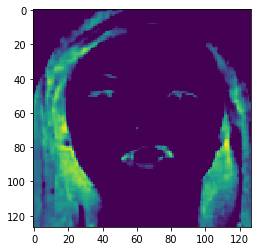

In [116]:
plt.imshow(img_conv1[:,:,3])

In [90]:
model._modules.base[0][1].register_forward_hook

AttributeError: 'collections.OrderedDict' object has no attribute 'base'

In [89]:
model.forward(img)

tensor([[0.0021]], grad_fn=<SigmoidBackward>)

In [84]:
cnn_layer = 1
filter_pos = 1

layer_vis = CNNLayerVisualization(model, cnn_layer, filter_pos)

Iteration: 1 Loss: -1.96


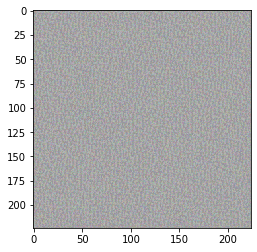

(224, 224, 3)
Iteration: 2 Loss: -6.63


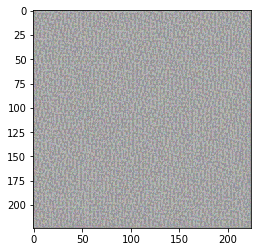

(224, 224, 3)
Iteration: 3 Loss: -10.30


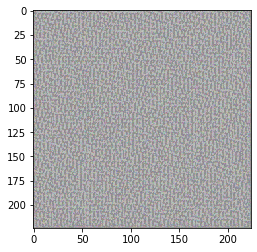

(224, 224, 3)
Iteration: 4 Loss: -13.54


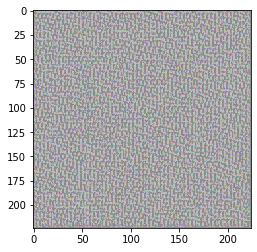

(224, 224, 3)
Iteration: 5 Loss: -16.36


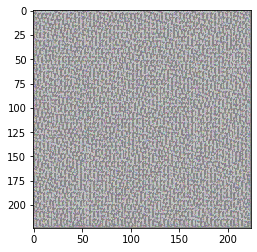

(224, 224, 3)
Iteration: 6 Loss: -18.79


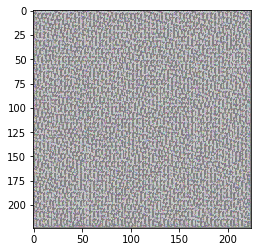

(224, 224, 3)
Iteration: 7 Loss: -20.93


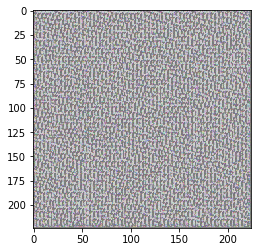

(224, 224, 3)
Iteration: 8 Loss: -22.89


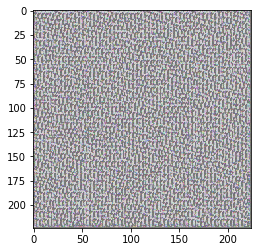

(224, 224, 3)
Iteration: 9 Loss: -24.72


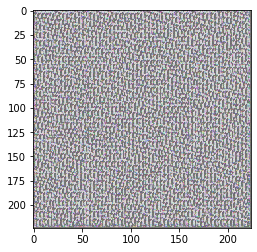

(224, 224, 3)
Iteration: 10 Loss: -26.48


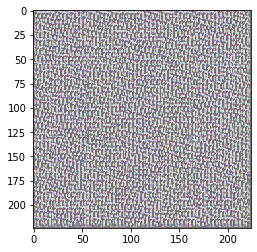

(224, 224, 3)
Iteration: 11 Loss: -28.18


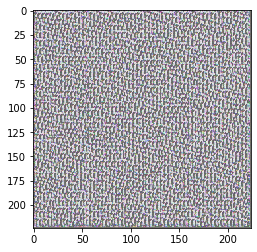

(224, 224, 3)
Iteration: 12 Loss: -29.86


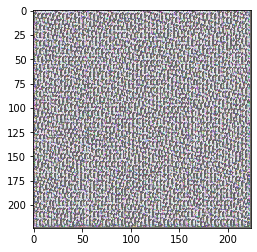

(224, 224, 3)
Iteration: 13 Loss: -31.51


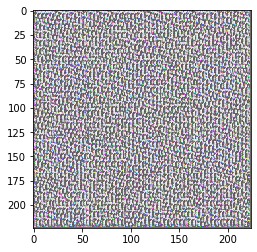

(224, 224, 3)
Iteration: 14 Loss: -33.16


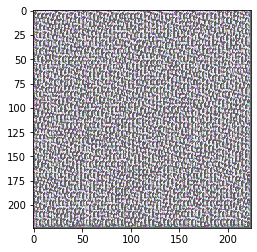

(224, 224, 3)
Iteration: 15 Loss: -34.79


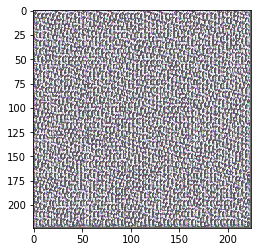

(224, 224, 3)
Iteration: 16 Loss: -36.42


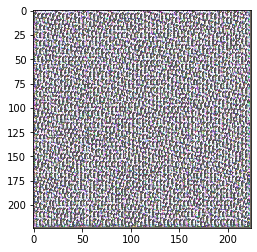

(224, 224, 3)
Iteration: 17 Loss: -38.05


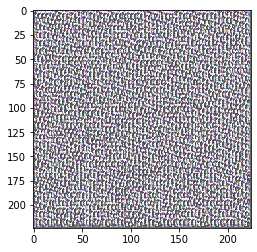

(224, 224, 3)
Iteration: 18 Loss: -39.67


KeyboardInterrupt: 

In [85]:
layer_vis.visualise_layer_with_hooks()

In [58]:
model.base[0][1]

Sequential(
  (unit1): XceptionUnit(
    (identity_conv): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (body): Sequential(
      (block1): DwsConvBlock(
        (conv): DwsConv(
          (dw_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pw_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block2): DwsConvBlock(
        (activ): ReLU()
        (conv): DwsConv(
          (dw_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
          (pw_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running